In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csic_database.csv


## Import libs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import keras
from keras.models import Model, load_model
# from keras.layers import Input, Embedding, Dense, Dropout, Flatten, Conv1D, MaxPool1D, Add, Reshape, LayerNormalization, Concatenate, GlobalMaxPooling1D


import tensorflow as tf
from tensorflow.keras.layers import Bidirectional,Embedding ,Dropout, Dense, Concatenate, Input, Flatten,Conv1D, MaxPool1D, Reshape, LayerNormalization, Concatenate, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.models import Model

# from keras.utils import plot_model, to_categorical, np_utils
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import optimizers

2024-03-25 12:43:06.862045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 12:43:06.862150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 12:43:06.999782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# pd.set_option("display.max_colwidth", 1024)

In [5]:
df = pd.read_csv('../input/csic_database.csv')

In [6]:
df = df.rename(columns={'Unnamed: 0':'Target'})
df.head(5)

,Target,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


## Data Preprocessing

### Change Label 0-> Normal; 1->attack

In [7]:
df['Target'] = df['Target'].apply(lambda x:0 if str(x) == 'Normal' else 1)
df.head()

,Target,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


### remove http1.1 in url

In [8]:
#Xóa http1.1 cuối url
df['URL'] = df['URL'].str[:-8]
df.head(5)

,Target,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp
1,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.jsp
3,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


### Data split ratio: train: 75%; test: 15%; valid: 10%

In [9]:
# Training : Validation : Test = 7.5 : 1.5 : 1.0
from sklearn.model_selection import train_test_split
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(df['URL'], df['Target'], test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 


print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)

print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)

print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (45798,)
y_train shape (45798,)
X_val shape (9160,)
y_val shape (9160,)
X_test shape (6107,)
y_test shape (6107,)


In [10]:
X_train

11499    http://localhost:8080/tienda1/publico/registro...
44949    http://localhost:8080/tienda1/publico/pagar.js...
43412    http://localhost:8080/tienda1/publico/autentic...
1709     http://localhost:8080/tienda1/publico/vaciar.jsp 
32502        http://localhost:8080/tienda1/imagenes/1.gif 
                               ...                        
54343    http://localhost:8080/tienda1/publico/entrar.j...
38158    http://localhost:8080/tienda1/publico/caracter...
860          http://localhost:8080/tienda1/imagenes/3.gif 
15795    http://localhost:8080/tienda1/miembros/editar....
56422    http://localhost:8080/tienda1/publico/autentic...
Name: URL, Length: 45798, dtype: object

### URL decoder

In [11]:
#url decoder
import urllib.parse
def url_decode(encoded_URL):
  return urllib.parse.unquote(encoded_URL)

### URL Data Normalize and padding

In [12]:
def load_data(urls, max_length=1000):
    urls = [s.lower() for s in urls]
    url_list = []
    for url in urls:
        # url decode
        decoded_url = url_decode(url)
        # unicode encode
        encoded_url = [ord(x) for x in str(decoded_url).strip()]
        encoded_url = encoded_url[:max_length]
        url_len = len(encoded_url)
        if url_len < max_length:
            # zero padding
            encoded_url += ([0] * (max_length - url_len))
        url_list.append((encoded_url))
    # convert to numpy array
    url_list = np.array(url_list)
    return url_list

In [13]:
train_data = load_data(X_train)
val_data = load_data(X_val)
test_data = load_data(X_test)

In [14]:
print(train_data)
print(val_data)
print(test_data)

[[104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 ...
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]]
[[104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 ...
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]]
[[104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 ...
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]
 [104 116 116 ...   0   0   0]]


### Create label function

In [15]:
def create_label(labels):
  class_list = [x for x in labels]
  classes = np.array(class_list)
  return classes

In [16]:
train_classes = create_label(y_train)
val_classes = create_label(y_val)
test_classes = create_label(y_test)

In [17]:
print(train_classes)
print(val_classes)
print(test_classes)

[0 1 1 ... 0 0 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 0]


## Define deep learning model

In [18]:
# def create_model(input_max_size, embedding_size, kernel_sizes, dropout):

#   # Input Layer
#   # URLdecode -> Unicode encode -> Give the URL converted to npumpy.darray as Input。
#   inputs = Input(shape=(input_max_size,), name='URL_input')

#   # Embedding Layer
#   x = Embedding(0xffff, embedding_size, name='Embedding')(inputs)
#   x = Reshape((input_max_size, embedding_size), name='Reshape_into_128_legnth_vector')(x)

#   # Convolution Layers
#   convolution_output = []

#   for kernel_size in kernel_sizes:
#     conv1 = Conv1D(64, kernel_size, activation='relu', padding='same', strides=1)(x)
#     pool1 = MaxPool1D(pool_size=kernel_size, padding='same', strides=1)(conv1)
#     conv2 = Conv1D(64, kernel_size, activation='relu', padding='same', strides=1)(pool1)
#     pool2 = GlobalMaxPooling1D()(conv2)
#     convolution_output.append(pool2)

#   # concat output
#   x = Concatenate(name='Concat_the_outputs')(convolution_output)

#   # reshape into 256 length vector
#   x = Reshape((256, ), name='Reshape_into_256_length_vector')(x)

#   # Fully Connected Layers
#   x = Dense(64, activation='relu', name='FullyConnectedLayer')(x)

#   # Batch Normalization
#   x = BatchNormalization()(x)

#   # DropOut
#   x = Dropout(dropout)(x)

#   # Fully Connected Layers
#   predictions = Dense(1, activation='sigmoid', name='Prediction')(x)

#   model = Model(inputs=inputs, outputs=predictions, name='Character-level_CNN')

#   return model



def create_model(input_max_size, embedding_size, kernel_sizes, dropout):

  # Input Layer
  # URLdecode -> Unicode encode -> Give the URL converted to npumpy.darray as Input。
  inputs = Input(shape=(input_max_size,), name='URL_input')

  # Embedding Layer
  x = Embedding(0xffff, embedding_size, name='Embedding')(inputs)
  x = Reshape((input_max_size, embedding_size), name='Reshape_into_128_legnth_vector')(x)

  # Convolution Layers
  convolution_output = []

  
  conv1 = Conv1D(64, kernel_size, activation='relu', padding='same', strides=1)(x)
  pool1 = MaxPool1D(pool_size=kernel_size, padding='same', strides=1)(conv1)
  conv2 = Conv1D(64, kernel_size, activation='relu', padding='same', strides=1)(pool1)
  pool2 = GlobalMaxPooling1D()(conv2)
  convolution_output.append(pool2)

  # concat output
  x = Concatenate(name='Concat_the_outputs')(convolution_output)

  # reshape into 256 length vector
  x = Reshape((64, ), name='Reshape_into_256_length_vector')(x)

  # Fully Connected Layers
  x = Dense(64, activation='relu', name='FullyConnectedLayer')(x)

  # Batch Normalization
  x = BatchNormalization()(x)

  # DropOut
  x = Dropout(dropout)(x)

  # Fully Connected Layers
  predictions = Dense(1, activation='sigmoid', name='Prediction')(x)

  model = Model(inputs=inputs, outputs=predictions, name='Character-level_CNN')

  return model  

### Parameter

In [19]:
# config
learning_rate = 0.001
epochs = 200

input_max_size = 1000
embedding_size = 128
# kernel_sizes = [4,5,6,7]
kernel_size = 2
dropout = 0.5

loss = 'binary_crossentropy'
optimizer = 'adam'

batch_size = 128

model_filepath = 'model_dir/model'
checkpoint_filepath = 'logs/checkpoint.weights.h5'

### Visualize the shape of Model

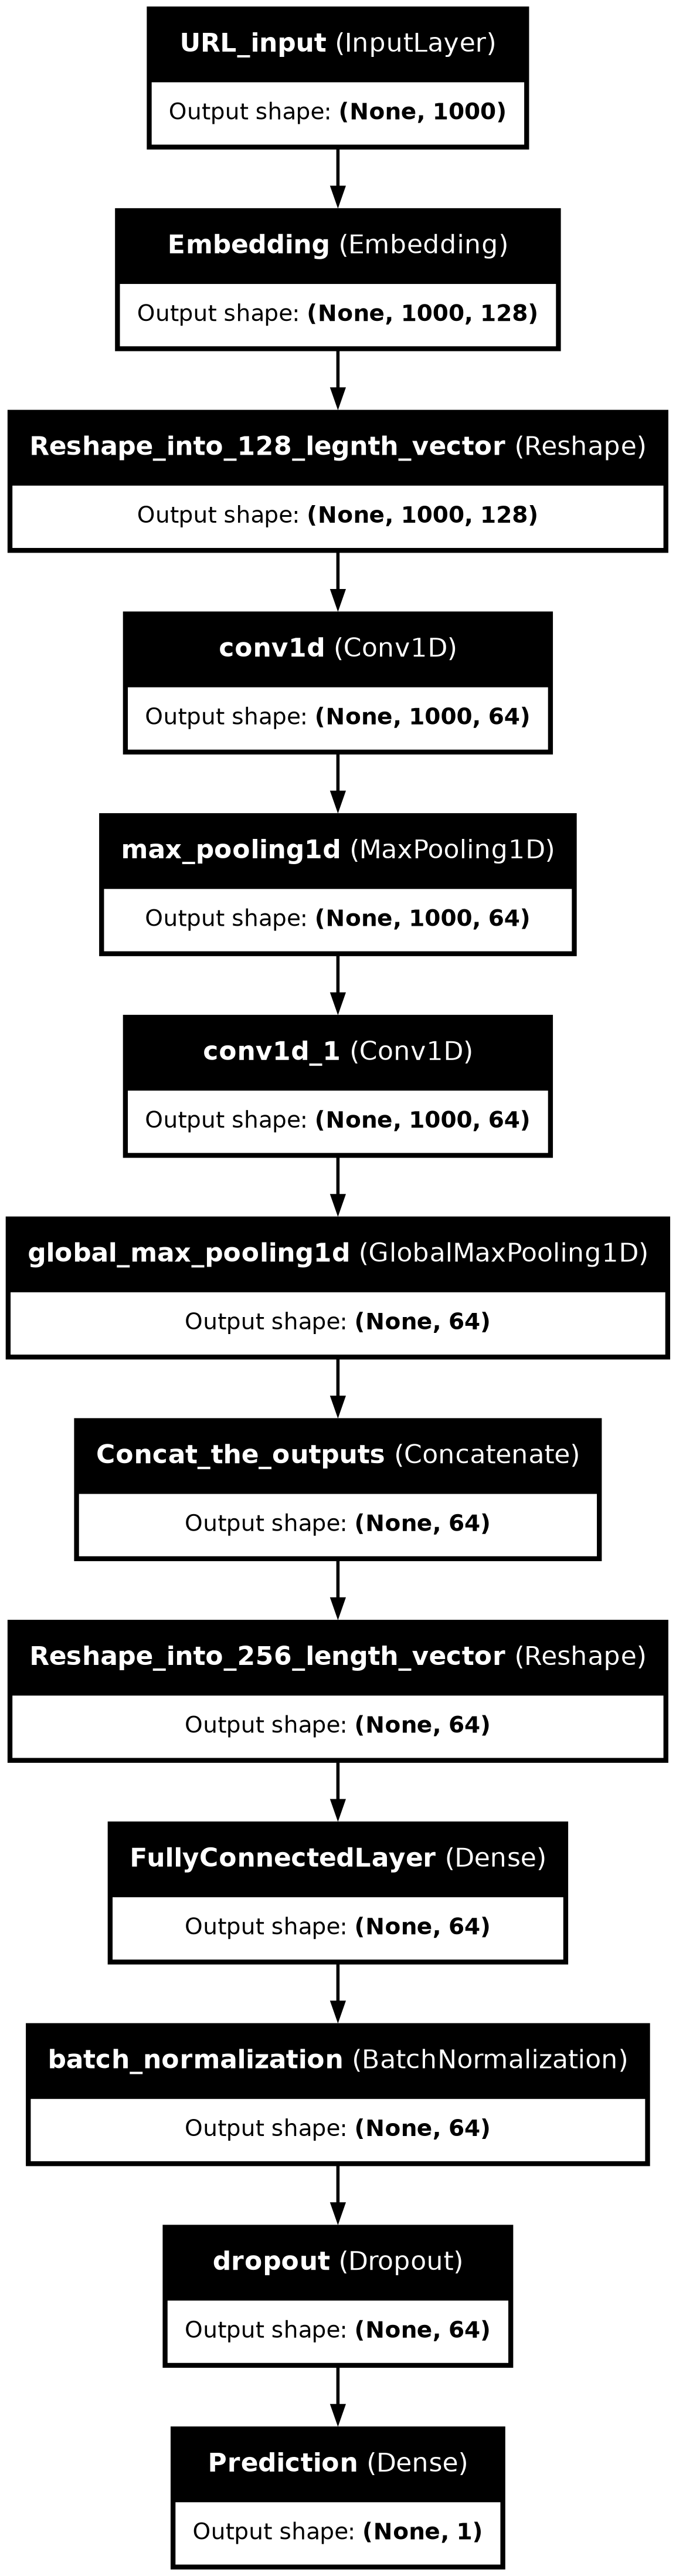

In [20]:
from tensorflow.keras.utils import plot_model
# Tạo model
model = create_model(input_max_size, embedding_size, kernel_size, dropout)

# Vẽ hình của model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Trainning processing

In [21]:
def train(learning_rate, input_max_size, embedding_size, kernel_sizes, dropout, loss, optimizer, train_data, train_classes, epochs, batch_size, val_data, val_classes, model_filepath):

    # optimize learning_rate
    start = learning_rate
    stop = learning_rate * 0.01
    learning_rates = np.linspace(start, stop, epochs)

    # Create model
    model = create_model(input_max_size, embedding_size, kernel_sizes, dropout)
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy', Precision(), Recall(), 'binary_accuracy', 'categorical_accuracy'])
    
    tf_callback = TensorBoard(log_dir="logs", histogram_freq=1)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
        )


    # tranning model
    model.fit(train_data, train_classes,
              epochs=epochs,
              batch_size=batch_size,
              verbose=1,
              validation_data=(val_data, val_classes),
              callbacks=[model_checkpoint_callback]
              )

    model.save(model_filepath + '.h5')
    model.save_weights(model_filepath + '_weight.weights.h5')

In [22]:
print("Beigin Trainning")
train(learning_rate, input_max_size, embedding_size, kernel_size, dropout, loss, optimizer, train_data, train_classes, epochs, batch_size, val_data, val_classes, model_filepath)
print("End Trainning")

Beigin Trainning
Epoch 1/200
  2/358 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5312 - binary_accuracy: 0.5312 - categorical_accuracy: 0.0000e+00 - loss: 0.7171 - precision: 0.4055 - recall: 0.5265

I0000 00:00:1711370700.292701     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


358/358 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - accuracy: 0.7803 - binary_accuracy: 0.7803 - categorical_accuracy: 0.3678 - loss: 0.3988 - precision: 0.7164 - recall: 0.7681 - val_accuracy: 0.8008 - val_binary_accuracy: 0.8008 - val_categorical_accuracy: 0.4611 - val_loss: 0.3834 - val_precision: 1.0000 - val_recall: 0.5145
Epoch 2/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8405 - binary_accuracy: 0.8405 - categorical_accuracy: 0.4051 - loss: 0.2691 - precision: 0.7968 - recall: 0.8185 - val_accuracy: 0.8134 - val_binary_accuracy: 0.8134 - val_categorical_accuracy: 0.4611 - val_loss: 0.3088 - val_precision: 0.9981 - val_recall: 0.5464
Epoch 3/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8434 - binary_accuracy: 0.8434 - categorical_accuracy: 0.4077 - loss: 0.2596 - precision: 0.8070 - recall: 0.8128 - val_accuracy: 0.8337 - val_binary_accuracy: 0.8337 - val_categorical_accuracy: 0.4611 - val_loss: 0.4557 - val_precision: 0.7121 - val_recall: 0.9984
Epoch 4

### Predict and evaluate

In [23]:
model_filepath = 'model_dir/model'
model = load_model(model_filepath+'.h5')

In [24]:
result = model.evaluate(test_data, test_classes, verbose=1)

# print("test_loss: ", test_loss)
# print("test_accuracy: ", test_accuracy)
# print("test_precision: ", test_precision)
# print("test_recall: ", test_recall)

print("test_loss: ", result[0])
print("test_accuracy: ", result[1])
print("test_precision: ", result[4])
print("test_recall: ", result[5])

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8518 - binary_accuracy: 0.8518 - categorical_accuracy: 0.4000 - loss: 0.2842 - precision: 0.7440 - recall: 0.9913
test_loss:  0.27377840876579285
test_accuracy:  0.8583592772483826
test_precision:  0.7522281408309937
test_recall:  0.9879047870635986
